<a href="https://colab.research.google.com/github/guthi1/technical-analysis-trading-dumpster-fire/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PolyFinances article

In [1]:
!nvidia-smi

Sat Feb 18 21:29:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Install required librairy
!pip install yfinance
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 799.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

#### Helper function

In [2]:
import os
import contextlib
@contextlib.contextmanager
def directory(name):
  ret = os.getcwd()
  os.chdir(name)
  yield None
  os.chdir(ret)

import subprocess
def run(input, exception_on_failure=False):
  try:
    program_output = subprocess.check_output(f"{input}", shell=True, universal_newlines=True, stderr=subprocess.STDOUT)
  except Exception as e:
    if exception_on_failure:
      raise e
    program_output = e.output

    return program_output

def runp(input, exception_on_failure=False):
    print(input)
    print(run(input, exception_on_failure))


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import yfinance as yf
from tqdm import tqdm

#### Params

In [6]:
DEBUG = False
DATA_DIR = "data/"
DATA_CANDLE = "data/candle/"
DATA_NORMAL = "data/normal/"
!mkdir data
!mkdir data/candle
!mkdir data/normal
PRICE_INTERVAL = 2 # In minute, Must be in: 1m,2m,5m,15m,30m,60m,90m
WINDOWS_INTERVAL = 60 # In minute, must be > than PRICE_INTERVAL
assert WINDOWS_INTERVAL > PRICE_INTERVAL, "window for analysis must be greater than the price interval"

HOLD = 0
BUY = 1
SELL = 2

## Create Dataset

In [5]:
tickers = ["TSLA","DKNG", "PLTR", "AMZN", "AAPL", "F", "AMD", "NVDA", "MARA", "NU", "NIO", "SNAP", "GOOGL", "SWN", "XP", "INTC", "CCL", "GOOG", "SOFI", "MSFT", "T", "BAC", "UBER", "OPEN", "AMC", "CS", "SHOP", "DVN", "CSCO", "META", "RIG", "DASH", "ITUB", "AMCR", "COIN", "RBLX", "LUMN", "LYFT", "AAL", "GOLD", "KMI", "CNNA", "XOM", "OXY", "KGC", "OKYO", "ROKU", "RIOT", "PFE", "ISEE", "PARA", "BABA", "MRO", "GRAB", "TOST", "SIRI", "PBR", "UUU", "AUY", "VALE", "KO", "RIVN", "PCG", "STEM", "NOK", "SI", "CMCSA", "LU", "CTRA", "WFC", "ET", "SOUN", "MPW", "GM", "INZY", "SPCE", "JNJ", "LYNG", "CSX", "C", "TLRY", "WMB", "FTI", "FTCH", "DBX", "FCX", "NCLH", "ABNB", "COP", "SQ", "TSM", "BMY", "BHC", "SABR", "FSLY", "MU", "PLUG", "CVE", "AEM", "BAX", "KHC", "HL", "NKLA", "QS", "PINS", "CVX", "HAL", "DIS", "MRK", "NEE", "EQT", "EXC", "BKR", "TWLO", "HOOD", "AMAT", "SLB", "XPEV", "HST", "DNB", "PTON", "HBI", "X", "OSH", "MRVL", "AR", "CLF", "NEM", "CHPT", "ELAN", "FUBO", "WMT", "TTD", "BTG", "MS", "AMAM", "CRM", "PG", "RDFN", "BSX", "KDP", "SNOW", "JPM", "HPE", "PR", "MO", "CX", "U", "WU", "PPL", "YMM", "RRC", "PDD", "LAZR", "NWL", "KOS", "TAL", "UAA", "MDLZ", "CVS", "MET", "ONEM", "CRK", "VTRS", "ON", "NET", "UNP", "ASX", "CHWY", "ARR", "SBUX", "MDT", "IQ", "UPST", "IAG", "UMC", "STLA", "IBN", "RITM", "NYCB", "GGB", "CPG", "FCEL", "RTX", "AG", "AGNC"]

In [6]:
# Download the data
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5d",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        interval = f"{PRICE_INTERVAL}m",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # attempt repair of missing data or currency mixups e.g. $/cents
        repair = True,
        # use threads for mass downloading
        threads = True
    )

print(f"Number of row: {len(data)}")
data.head()

[************          24%                       ]  45 of 186 completedDNB: fixed 1/31 value=0 errors in 2m price data: [Timestamp('2023-02-13 09:30:00-0500', tz='America/New_York')]
[*********************100%***********************]  186 of 186 completed

1 Failed download:
- LYNG: No data found, symbol may be delisted
Number of row: 975


SNOW                                      \
                                 Open        High         Low       Close   
Datetime                                                                    
2023-02-13 09:30:00-05:00  158.500000  160.100006  158.500000  159.740005   
2023-02-13 09:32:00-05:00  159.970001  160.690002  158.220001  158.440002   
2023-02-13 09:34:00-05:00  158.169998  158.289902  157.250000  157.365005   
2023-02-13 09:36:00-05:00  157.360001  158.313004  157.050003  157.591400   
2023-02-13 09:38:00-05:00  157.899994  158.600006  157.550003  158.550003   

                                                 PLUG                  \
                            Adj Close Volume     Open    High     Low   
Datetime                                                                
2023-02-13 09:30:00-05:00  159.740005  90202  15.3400  15.360  15.170   
2023-02-13 09:32:00-05:00  158.440002  38847  15.1800  15.220  15.020   
2023-02-13 09:34:00-05:00  157.365005  29870  15.0400  15.080  14.870   
2023-02-13 09:36:00-05:00  157.591400  15079  14.8901  15.035  14.885   
2023-02-13 09:38:00-05:00  158.550003  25926  15.0150  15.130  15.010   

                                    ...    VTRS                            \
                             Close  ...     Low   Close Adj Close  Volume   
Datetime                            ...                                     
2023-02-13 09:30:00-05:00  15.1701  ...  11.790  11.820    11.820  106149   
2023-02-13 09:32:00-05:00  15.0400  ...  11.800  11.840    11.840   24808   
2023-02-13 09:34:00-05:00  14.8900  ...  11.840  11.864    11.864   42986   
2023-02-13 09:36:00-05:00  15.0200  ...  11.855  11.865    11.865   29398   
2023-02-13 09:38:00-05:00  15.1200  ...  11.860  11.880    11.880  128529   

                            LUMN                                           
                            Open    High    Low   Close Adj Close  Volume  
Datetime                                                                   
2023-02-13 09:30:00-05:00  3.920  3.9500  3.860  3.8600    3.8600  917701  
2023-02-13 09:32:00-05:00  3.860  3.9150  3.855  3.9150    3.9150  258486  
2023-02-13 09:34:00-05:00  3.910  3.9300  3.900  3.9000    3.9000   92376  
2023-02-13 09:36:00-05:00  3.910  3.9399  3.900  3.9282    3.9282  123768  
2023-02-13 09:38:00-05:00  3.925  3.9300  3.915  3.9250    3.9250   65055  

[5 rows x 1116 columns]

Build dataset

In [7]:
plot_number = 0
# Dataframe to save the value we need
dataset={"candle_path": [], "action": [], "info": [], "filename": []}

In [8]:
# Let's try it for ford first
for ticker in tqdm(tickers):
    ticker_data = data[ticker].copy(deep=True)
    ticker_data.dropna() # Sanity check
    ticker_data["datetime"] = ticker_data.index

    # Find Dataset range
    day = ticker_data['datetime'].min()
    last_end = ticker_data['datetime'].max()
    if DEBUG: print(f"From {day} to {last_end}")

    plt.close()

    while day <= last_end:
        if DEBUG: print(f"{day}")

        start_window = day
        end_window = start_window + datetime.timedelta(minutes=WINDOWS_INTERVAL)
        end_of_day = day + datetime.timedelta(hours=6.5)

        while start_window < end_of_day - datetime.timedelta(minutes=WINDOWS_INTERVAL):
            if DEBUG: print(f"    {start_window}")

            # Create a mask for the desired window
            mask = (ticker_data['datetime'] > start_window) & (ticker_data['datetime'] <= end_window)
            window_data = ticker_data.loc[mask]
            """ TODO: This could be change to something smarter """
            mean_close = window_data.Close.mean()

            # "up" dataframe will store the stock_prices when the closing stock 
            # price is greater than or equal to the opening stock prices
            up = window_data[window_data.Close >= window_data.Open]
            col1 = 'red'

            # "down" dataframe will store the stock_prices when the closing stock 
            # price is lesser than the opening stock prices
            down = window_data[window_data.Close < window_data.Open]
            col2 = 'blue'

            # Setting width of candlestick elements
            width = .0005
            width2 = .00008

            # Plotting up prices of the stock
            plt.bar(up.datetime, up.Close-up.Open, width, bottom=up.Open, color=col1)
            plt.bar(up.datetime, up.High-up.Close, width2, bottom=up.Close, color=col1)
            plt.bar(up.datetime, up.Low-up.Open, width2, bottom=up.Open, color=col1)

            # Plotting down prices of the stock
            plt.bar(down.datetime, down.Close-down.Open, width, bottom=down.Open, color=col2)
            plt.bar(down.datetime, down.High-down.Open, width2, bottom=down.Open, color=col2)
            plt.bar(down.datetime, down.Low-down.Close, width2, bottom=down.Close, color=col2)
            plt.axis('off')

            # Saving the candle plot
            plt_name = f"{plot_number}_{ticker}.png"
            plt.savefig(f"{DATA_CANDLE}{plt_name}", format="png")
            plt.close()    
            dataset["filename"].append(plt_name)
            dataset["candle_path"].append(DATA_CANDLE)
            
            # Update var
            plot_number += 1
            start_window = end_window
            end_window = start_window + datetime.timedelta(minutes=WINDOWS_INTERVAL)

            # Check if it's a hold, buy and sold
            """ TODO: This could be change to something smarter """
            mask = (ticker_data['datetime'] > start_window) & (ticker_data['datetime'] <= end_window)
            window_data = ticker_data.loc[mask]
            mean_close_next_interval = window_data.Close.mean()

            diff = mean_close_next_interval / mean_close
            if diff > 1.002:
                dataset["action"].append(BUY)
            elif diff < 0.998:
                dataset["action"].append(SELL)
            else:
                dataset["action"].append(HOLD)

            # For debugging later
            dataset["info"].append(f"{ticker}: {start_window}")

        day += datetime.timedelta(days=1)

100%|██████████| 186/186 [12:06<00:00,  3.91s/it]


In [9]:
dataset = pd.DataFrame(data=dataset)
dataset.head()

,candle_path,action,info,filename
0,data/candle/,1,TSLA: 2023-02-13 10:30:00-05:00,0_TSLA.png
1,data/candle/,0,TSLA: 2023-02-13 11:30:00-05:00,1_TSLA.png
2,data/candle/,0,TSLA: 2023-02-13 12:30:00-05:00,2_TSLA.png
3,data/candle/,0,TSLA: 2023-02-13 13:30:00-05:00,3_TSLA.png
4,data/candle/,0,TSLA: 2023-02-13 14:30:00-05:00,4_TSLA.png


# Save or open data

In [10]:
dataset.to_csv("data/dataset.csv")

In [11]:
runp("zip -r /content/data.zip /content/data")
from google.colab import files
files.download("/content/data.zip")

zip -r /content/data.zip /content/data
None


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
runp(f"unzip -q /content/data.zip")
runp(f"rm -rf data")
runp("mv /content/content/data /content/data")


unzip -q /content/data.zip
None
rm -rf data
None
mv /content/content/data /content/data
None


In [8]:
dataset = pd.read_csv("data/dataset.csv")
# dataset = dataset.sample(frac=0.1, axis=0)
print(len(dataset))
dataset.head()

5580


,Unnamed: 0,candle_path,action,info,filename
0,0,data/candle/,1,TSLA: 2023-02-13 10:30:00-05:00,0_TSLA.png
1,1,data/candle/,0,TSLA: 2023-02-13 11:30:00-05:00,1_TSLA.png
2,2,data/candle/,0,TSLA: 2023-02-13 12:30:00-05:00,2_TSLA.png
3,3,data/candle/,0,TSLA: 2023-02-13 13:30:00-05:00,3_TSLA.png
4,4,data/candle/,0,TSLA: 2023-02-13 14:30:00-05:00,4_TSLA.png


In [9]:
dataset['action'].value_counts().to_frame().reset_index().rename(columns={'index':'values', 'values':'count'})

,values,action
0,1,2121
1,0,2080
2,2,1379


## DataLoader

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Let's create a data loader for the dataset we created

In [11]:
class TechnicalAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, data, chart_dir, transform=None):
        self.df = data
        self.img_dir = chart_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]["filename"])
        image = read_image(img_path)
        image = image / 255
        label = self.df.iloc[idx]["action"]
        if self.transform:
            image = self.transform(image)
        return image, label

Now that we have our dataset, we will need to split it in a training and validation set and we will need a data loader to be able to have minibatch.

In [12]:
def train_test_split(df, frac=0.2):
    
    # get random sample 
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

In [13]:
from torch.utils.data import DataLoader

train_dataset, test_dataset = train_test_split(dataset)
resize_transform = transforms.Resize(size=(256, 256))
train_technical_analysis_dataset = TechnicalAnalysisDataset(train_dataset, DATA_CANDLE, transform=resize_transform)
test_technical_analysis_dataset = TechnicalAnalysisDataset(test_dataset, DATA_CANDLE, transform=resize_transform)

train_loader = torch.utils.data.DataLoader(
    train_technical_analysis_dataset, batch_size=128, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
      test_technical_analysis_dataset, batch_size=128, shuffle=False, num_workers=2
)

torch.Size([256, 256, 4])
0


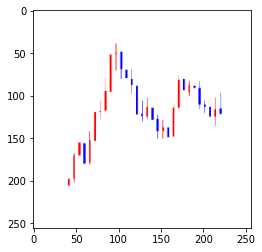

In [14]:
# Sanity check
img, label = train_technical_analysis_dataset.__getitem__(1)
img = img.permute(1, 2, 0)
print(img.shape)
print(label)
plt.imshow(img)
plt.show()

In [15]:
print(f"Training: {len(train_technical_analysis_dataset)}")

Training: 4464


## Training architecture

In [16]:
def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Number of the current training epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    train_loader: DataLoader
      The training dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.
    optimizer: Optimizer
      An Optimizer object for the Adam optimizer.

    Outputs: Returns average train_acc and train_loss for the current epoch.
  """
  train_acc = 0.
  train_loss = 0.
  nb_data = 0 
  model.train()
  for inputs, labels in train_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)

      # Zeros the parameter gradient
      optimizer.zero_grad()
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Get stats
      train_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      train_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  train_loss = train_loss / len(train_loader)
  train_acc = train_acc / nb_data

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Number of the current epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.

    Outputs: Returns average val_acc and val_loss for the current epoch.
  """
  val_acc = 0.
  val_loss = 0.
  nb_data = 0

  model.eval()
  for inputs, labels in val_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Get stats
      val_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      val_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_acc / nb_data

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

## Models



### MLP

In [17]:
from torch.nn.modules.dropout import Dropout
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4*256*256, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(512, 254),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(254, 3)
        )
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        out = self.model(x)
        return out

In [18]:
import time
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 12

  mlp = MLP().to(device)
  nb_params = sum(p.numel() for p in mlp.parameters())
  print(mlp)
  print(f"Number of parameter: {nb_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters())

  tic = time.perf_counter()
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, mlp, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, mlp, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

  toc = time.perf_counter()
  print(f"Time to train {toc - tic:0.4f} seconds")

MLP(
  (model): Sequential(
    (0): Linear(in_features=262144, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.05, inplace=False)
    (15): Linear(in_features=512, out_features=254, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.05, inplace=False)
    (18): Linear(in_features=254, out_features=3, bias=True)
  )
)
Number of parameter: 541726203
Epoch: 0 | Train Acc: 0.368504 | Train Loss: 2.213160
Epoch: 0 | Val Acc: 0.368280   | Val Loss: 1.090128
Epoch: 1 | Train Acc: 0.368504 | Train Lo

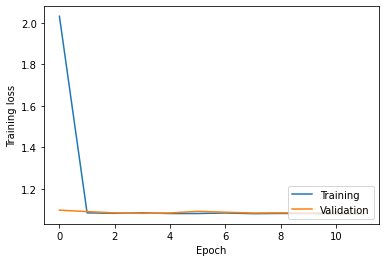

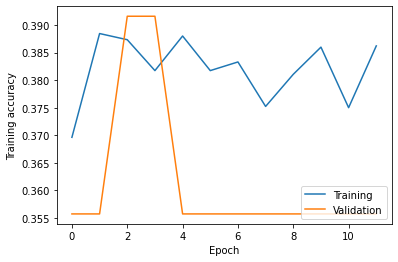

In [27]:
if __name__ == "__main__":
    plt.figure(0)
    plt.ylabel("Training loss")
    plt.xlabel("Epoch")
    plt.figure(1)
    plt.ylabel("Training accuracy")
    plt.xlabel("Epoch")

    plt.figure(0)
    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Validation")
    plt.legend(loc="lower right")

    plt.figure(1)
    plt.plot(train_accs, label="Training")
    plt.plot(val_accs, label="Validation")
    plt.legend(loc="lower right")

### Resnet-18

After that, we can try with Resnet-18. This might be overkill, but why not, I won't trade any real money in the end

In [17]:
class ResidualBlock(nn.Module):
  """This class implements the Residual Block used in ResNet-18."""

  def __init__(self, in_channels, channels, conv_stride=1, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResidualBlock class.

      in_channels: int
        Number of channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer and downsampling convolution (if required).
      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Initialization for convolution layer weights.
    """
    super(ResidualBlock, self).__init__()

    self.in_channels = in_channels
    self.channels = channels
    self.conv_stride = conv_stride
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(in_channels, channels, 3, stride=conv_stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(channels)

    self.residual_connection = self.residual(in_channels, channels, conv_stride)

    # Initialize weights for conv1 and conv2
    if initialization == "xavier_normal":
      nn.init.xavier_normal_(self.conv1.weight)
      nn.init.xavier_normal_(self.conv2.weight)
    elif initialization == "xavier_uniform": 
      nn.init.xavier_uniform_(self.conv1.weight)
      nn.init.xavier_uniform_(self.conv2.weight)
    elif initialization == "kaiming_normal": 
      nn.init.kaiming_normal_(self.conv1.weight)
      nn.init.kaiming_normal_(self.conv2.weight)
    else:
      raise Exception("Invalid initialization")

  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def residual(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride to use for downsampling 1x1 convolution.

      Output: Returns an nn.Sequential object which computes the identity function of the input if stride is 1
              and the number of input channels equals the number of output channels. Otherwise, it returns an
              nn.Sequential object that downsamples its input using a 1x1-conv of the stride specified and
              followed by a BatchNorm2d.
    """
    layers = []
    if conv_stride != 1 or in_channels != channels:
      layers.append(nn.Conv2d(in_channels, channels, 1, stride=conv_stride, padding=0, bias=False))
      layers.append(nn.BatchNorm2d(channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    """
      x: Tensor
        Input to the block.

      Outputs: Returns the output of the forward pass of the block.
    """
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += self.residual_connection(identity)
    out = self.activation(out)

    return out

We can than create the model

In [18]:
class ResNet18(nn.Module):
  """This class implements the ResNet-18 architecture from its components."""

  def __init__(self, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResNet18 class.

      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Weight initialization to use.
    """
    super(ResNet18, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str
    self.initialization = initialization

    self.conv1 = nn.Conv2d(4, 64, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._create_layer(64, 64) 
    self.layer2 = self._create_layer(64, 128, conv_stride=2)
    self.layer3 = self._create_layer(128, 256, conv_stride=2)
    self.layer4 = self._create_layer(256, 512, conv_stride=2)  
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(512, 3)
  
  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def _create_layer(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels present in the input to the layer.
      out_channels: int
        Number of output channels for the layer, i.e., the number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer in the block and the downsampling convolution (if required).

      Outputs: Returns an nn.Sequential object giving a "layer" of the ResNet, consisting of 2 blocks each.
    """
    return nn.Sequential(
        ResidualBlock(in_channels, channels, conv_stride=conv_stride, activation_str=self.activation_str, initialization=self.initialization),
        ResidualBlock(channels, channels, conv_stride=1, activation_str=self.activation_str, initialization=self.initialization)
    )

  def get_first_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the first convolution layer.
    """
    return self.conv1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the last convolution layer.
    """
    return list(self.layer4.modules())[1].conv2.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      x: Tensor
        Input to the network.

      Outputs: Returns the output of the forward pass of the network.
    """
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.linear(out)

    return out

In [19]:
# Parameter we will use
activation_str = "relu"
initialization = "xavier_normal"

In [20]:
# Training
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model = ResNet18(
    activation_str=activation_str,
    initialization=initialization
  ).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())
  
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
     

RuntimeError: ignored

In [ ]:
if __name__ == "__main__":
    torch.save(model, "resnet18")

In [ ]:
if __name__ == "__main__":
    model = torch.load("resnet18")

Let's see if the model learn something

We can finaly look how the model extract this information by looking at the learned filter

First layer

First layer filters


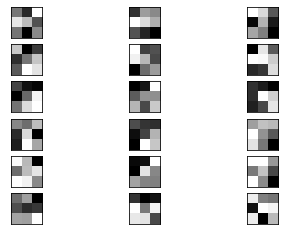

In [ ]:
def print_filter(filters, n_filter_to_display=6):
    # Normalize 
    f_min, f_max = filters.max(), filters.min()
    filters = (filters - f_min) / (f_max - f_min)

    i_idx = 1
    for f_idx in range(n_filter_to_display):
        filter = filters[f_idx, :, :, :]
        for p_idx in range(3):
            ax = plt.subplot(n_filter_to_display, 3, i_idx)
            ax.set_xticks([])
            ax.set_yticks([])
            # Plot
            plt.imshow(filter[p_idx,:,:], cmap='gray')
            i_idx += 1
    plt.show()
    
if __name__ == "__main__":
    print("First layer filters")
    first_filters = model.get_first_conv_layer_filters()
    print_filter(first_filters)

Last layer filters


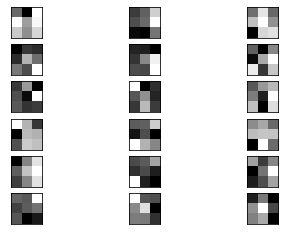

In [ ]:
if __name__ == "__main__":
    print("Last layer filters")
    last_filters = model.get_last_conv_layer_filters()
    print_filter(last_filters)

Let see what the graph look like with those filter

In [ ]:
if __name__ == "__main__":

    # Fin output size
    img, label = train_technical_analysis_dataset.__getitem__(0)
    # vis_image = img.permute(1, 2, 0)
    vis_image = img
    channel, dim_x_img, dim_y_img = vis_image.shape
    dim_out = (dim_x_img-3)//1 + 1

    output = np.zeros((64, dim_out, dim_out))

    for filter_idx in range(first_filters.shape[0]):
        filter = first_filters[filter_idx]

        for channel_i in range(filter.shape[0]):
            # Apply kernel
            kernel = filter[channel_i]
            img = vis_image[channel_i].numpy()
            for i in range(0, dim_out):
                for j in range(0, dim_out):
                    # Select part of the img
                    img_patch = img[i:i+3, j:j+3]
                    # Apply kernel
                    kernel_output = np.multiply(img_patch, kernel)
                    kernel_output = np.sum(kernel_output)
                    # Save output
                    output[filter_idx, i, j] = kernel_output

    from matplotlib.pyplot import figure
    figure(figsize=(10,10))

    ax = [plt.subplot(8,8,i+1) for i in range(64)]

    for i, a in enumerate(ax):
        a.set_xticks([])
        a.set_yticks([])

        a.imshow(output[i,:,:], cmap='gray')

    plt.subplots_adjust(wspace=0., hspace=0.1)


Last layer

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

if __name__ == "__main__":

    model_extract_last_features = create_feature_extractor(model, {"layer4": "layer4"})
    out = model_extract_last_features(vis_image.to(device))
    out['layer4'].shape

    figure(figsize=(10,10))

    ax = [plt.subplot(8,8,i+1) for i in range(64)]

    for i, a in enumerate(ax):
        a.set_xticks([])
        a.set_yticks([])

        image = out['layer4'].cpu().detach().numpy()[0, i,:,:]
        a.imshow(image, cmap='gray')

    plt.subplots_adjust(wspace=0., hspace=0.1)

### ViT

## Let's trade some stock and loose money, but in style hehe